In [1]:
%matplotlib inline
import sys
import os
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params, load_params
from dynamic_population_sim import DynamicPopulationSim

In [2]:
ug_total_pop_size = 13000

# ug_on_campus_pop_size = 6000
# ug_off_campus_pop_size = ug_total_pop_size - ug_on_campus_pop_size # 7000

ug_high_prev_pop_size = 2200
ug_low_prev_pop_size = ug_total_pop_size - ug_high_prev_pop_size # 10800

# ug_high_prev_on_campus_pop_size =  int(ug_high_prev_pop_size * ug_on_campus_pop_size / ug_total_pop_size) # 1015
# ug_high_prev_off_campus_pop_size = ug_high_prev_pop_size - ug_high_prev_on_campus_pop_size # 1185

# ug_low_prev_on_campus_pop_size = int(ug_low_prev_pop_size * ug_on_campus_pop_size / ug_total_pop_size) # 4984
# ug_low_prev_off_campus_pop_size = ug_low_prev_pop_size - ug_low_prev_on_campus_pop_size # 5816

In [3]:
base_params_free = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_free.yaml')[1]
base_params_selfiso = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_post_movein.yaml')[1]

/Users/jiayuewan/Documents/GitHub/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/Users/jiayuewan/Documents/GitHub/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [6]:
prev_incoming = 16 / 13000 / 0.9
prev_low = prev_incoming / 1.2
prev_high = prev_low * 2 
print('prev:', prev_incoming, prev_low, prev_high)

gateway_testing_fnr = 0.4
fraction_of_immediate_test = 0.73
prev_low_free = prev_low * (fraction_of_immediate_test * gateway_testing_fnr + (1 - fraction_of_immediate_test))
prev_high_free = prev_high * gateway_testing_fnr
print('prev_free:', prev_low_free, prev_high_free)

prev_low_identified_by_gateway = prev_low - prev_low_free
prev_high_identified_by_gateway = prev_high - prev_high_free
print('prev_gateway:', prev_low_identified_by_gateway, prev_high_identified_by_gateway)


prev: 0.0013675213675213675 0.0011396011396011397 0.0022792022792022795
prev_free: 0.0006404558404558406 0.0009116809116809119
prev_gateway: 0.0004991452991452991 0.0013675213675213675


In [7]:
print(prev_low_identified_by_gateway * ug_low_prev_pop_size, prev_high_identified_by_gateway * ug_high_prev_pop_size)

5.390769230769231 3.0085470085470085


In [39]:
# For reproducing red curves


n_iter = 200
n_days = 15 + 109
QI = np.zeros((n_iter, n_days))
QS = np.zeros((n_iter, n_days))
cumul = np.zeros((n_iter, n_days))
free_and_infectious = np.zeros((n_iter, n_days))

for i in range(n_iter):
    print(i)
    movein_free_params = base_params_free.copy()
    movein_selfiso_params = base_params_selfiso.copy()
    post_movein_params = base_params_post_movein.copy()
    
    movein_selfiso_params['population_size'] = ug_high_prev_pop_size
    movein_free_params["initial_ID_prevalence"] = 0
    movein_selfiso_params["initial_ID_prevalence"] = st.binom.rvs(ug_high_prev_pop_size, prev_high_free) / ug_high_prev_pop_size
    post_movein_params["initial_ID_prevalence"] = 0.5
    daily_selfiso_to_free_contacts_pp = 2
    daily_free_to_selfiso_contacts_pp = 1

    movein_contact_matrix = np.matrix(
        [[movein_free_params['expected_contacts_per_day'], daily_selfiso_to_free_contacts_pp],
        [daily_free_to_selfiso_contacts_pp, movein_selfiso_params['expected_contacts_per_day']]])

    movein_time_horizon = 15

    free_infectious_low_prev = st.binom.rvs(ug_low_prev_pop_size, prev_low_free)
    sampled_days = [random.randint(7, 13) for _ in range(free_infectious_low_prev)]
    counts_by_days = dict((t,sampled_days.count(t)) for t in set(sampled_days))
    counts_by_days = [counts_by_days[t] if t in counts_by_days else 0 for t in range(7, 14)]
    student_returns_by_days = [ug_low_prev_pop_size // 7] * 6 + [ug_low_prev_pop_size - ug_low_prev_pop_size // 7 * 6]
    
    free_group_population_dynamics = {
        t: {'S': student_returns_by_days[i] - counts_by_days[i], 'ID': counts_by_days[i]} 
         for i, t in enumerate(range(7,14))
    }
    selfiso_group_population_dynamics = {}

    dynamic_pop_sim = DynamicPopulationSim(
        movein_free_params,
        movein_selfiso_params,
        post_movein_params,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        selfiso_group_population_dynamics
    )

    sims = dynamic_pop_sim.movein_sim.sims

#    print("Initial population sizes: {} free, {} self-quarantined".format(sims[0].pop_size, 
#                                                                         sims[1].pop_size))
    for t in range(movein_time_horizon):
        dynamic_pop_sim.step()
#         print("After time {}, population sizes: {} free, {} self-quarantined".format(t,
#                                                                         sims[0].pop_size, 
#                                                                         sims[1].pop_size))
        QI[i, t] = sims[0].QI + sims[1].QI
        QS[i, t] = sims[0].QS + sims[1].QS
        free_and_infectious[i, t] = sum(sims[0].ID) + sum(sims[0].SyID_mild) + sum(
            sims[0].SyID_severe) + sum(sims[1].ID) + sum(sims[1].SyID_mild) + sum(sims[1].SyID_severe)
        cumul[i, t] = sims[0].cumulative_mild + sims[0].cumulative_severe + sims[1].cumulative_mild + sims[1].cumulative_severe
    #print("At end of time {}, initialized post-movein simulation with population {}".format(t, dynamic_pop_sim.post_movein_sim.pop_size))

    after_sim = dynamic_pop_sim.post_movein_sim

    for t in range(movein_time_horizon, n_days):
        dynamic_pop_sim.step()
#         print("After time {}, population sizes: {} in QI, {} in QS, {} free-and-infectious".format(t,
#             after_sim.QI, after_sim.QS, sum(after_sim.ID) + sum(after_sim.SyID_mild) + sum(after_sim.SyID_severe)))
        QI[i, t] = after_sim.QI
        QS[i, t] = after_sim.QS
        free_and_infectious[i, t] = sum(after_sim.ID) + sum(after_sim.SyID_mild) + sum(after_sim.SyID_severe)
        cumul[i, t] = after_sim.cumulative_mild + after_sim.cumulative_severe
        
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


Text(0.5, 1.0, 'Estimated cumulative number of cases over time in Scenario 1')

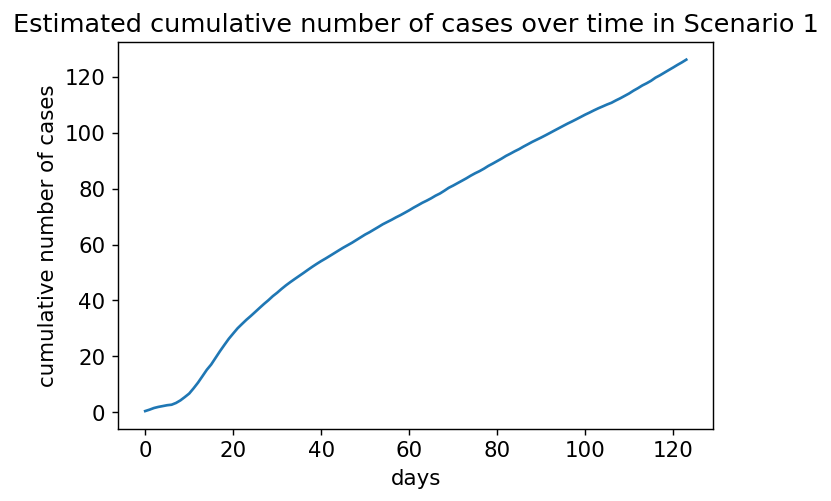

In [40]:
plt.rcParams['figure.dpi'] = 128

plt.plot(range(n_days), np.mean(cumul, axis=0)) # fall semester 0.7, get ?
plt.xlabel('days')
plt.ylabel('cumulative number of cases')
plt.title('Estimated cumulative number of cases over time in Scenario 1')

In [43]:
y = np.mean(cumul, axis=0)
(y[123] - y[40])/ 83

0.8683132530120483

In [44]:
np.savetxt('cumulative_scenario_1_full_200.out', y)

Text(0, 0.5, '# QI')

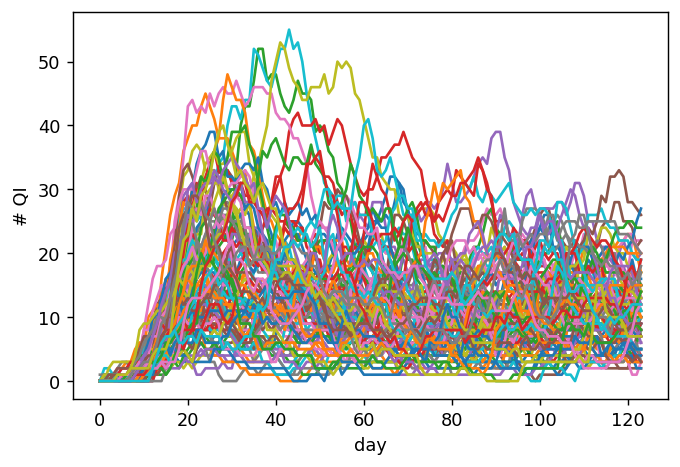

In [332]:
plt.rcParams['figure.dpi'] = 128

for i in range(n_iter):
    plt.plot(QI[i,:])
    
plt.xlabel('day')
plt.ylabel('# QI')

Text(0, 0.5, '# QS')

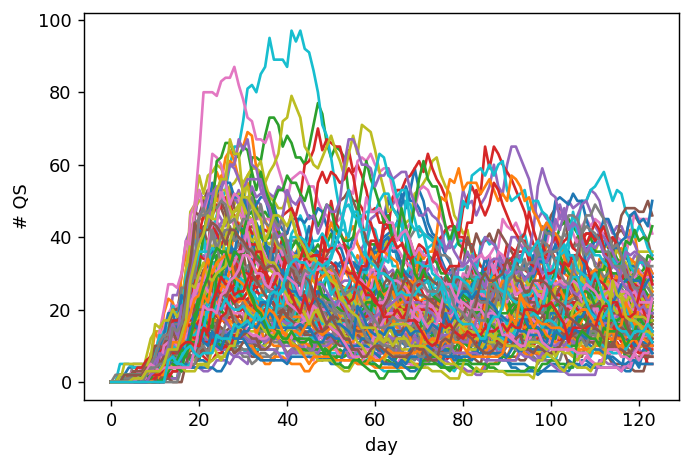

In [333]:
for i in range(n_iter):
    plt.plot(QS[i,:])
    
plt.xlabel('day')
plt.ylabel('# QS')

Text(0, 0.5, '# free and infectious')

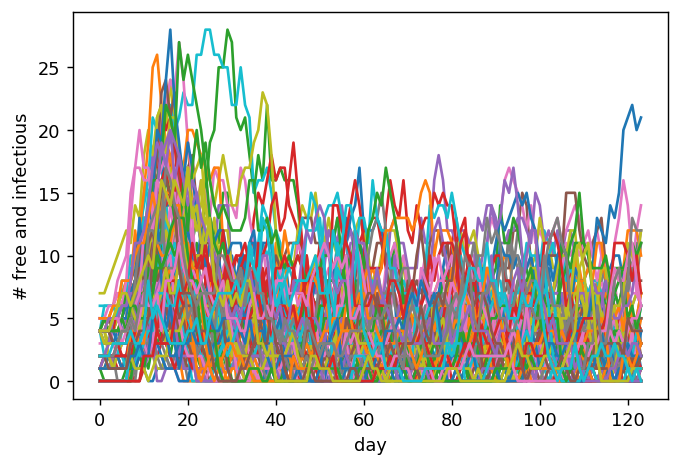

In [334]:
for i in range(n_iter):
    plt.plot(free_and_infectious[i,:])
    
plt.xlabel('day')
plt.ylabel('# free and infectious')

In [335]:
np.percentile(np.max(QI + QS, axis=1), 50)

71.5

In [336]:
np.percentile(np.max(QI + QS, axis=1), 90)

103.10000000000001

In [337]:
Q = QI + QS
np.percentile(np.max(Q[:, 36:], axis=1), 50)

65.5

In [338]:
np.percentile(np.max(Q[:, 36:], axis=1), 90)

91.30000000000003

In [355]:
ug_total_pop_size = 13000

# ug_on_campus_pop_size = 6000
# ug_off_campus_pop_size = ug_total_pop_size - ug_on_campus_pop_size # 7000

ug_high_prev_pop_size = 3300
ug_low_prev_pop_size = ug_total_pop_size - ug_high_prev_pop_size # 9700

# ug_high_prev_on_campus_pop_size =  int(ug_high_prev_pop_size * ug_on_campus_pop_size / ug_total_pop_size) # 1015
# ug_high_prev_off_campus_pop_size = ug_high_prev_pop_size - ug_high_prev_on_campus_pop_size # 1185

# ug_low_prev_on_campus_pop_size = int(ug_low_prev_pop_size * ug_on_campus_pop_size / ug_total_pop_size) # 4984
# ug_low_prev_off_campus_pop_size = ug_low_prev_pop_size - ug_low_prev_on_campus_pop_size # 5816

In [356]:
prev_incoming = 0.0075
prev_low = prev_incoming / 1.25
prev_high = prev_low * 2 
print('prev:', prev_incoming, prev_low, prev_high)

gateway_testing_fnr = 0.4
fraction_of_immediate_test = 0.73
prev_low_free = prev_low * (fraction_of_immediate_test * gateway_testing_fnr + (1 - fraction_of_immediate_test))
prev_high_free = prev_high * gateway_testing_fnr
print('prev_free:', prev_low_free, prev_high_free)

prev_low_identified_by_gateway = prev_low - prev_low_free
prev_high_identified_by_gateway = prev_high - prev_high_free
print('prev_gateway:', prev_low_identified_by_gateway, prev_high_identified_by_gateway)


prev: 0.0075 0.006 0.012
prev_free: 0.0033720000000000004 0.0048000000000000004
prev_gateway: 0.0026279999999999997 0.0072


In [357]:
print(prev_low_identified_by_gateway * ug_low_prev_pop_size, prev_high_identified_by_gateway * ug_high_prev_pop_size)

25.4916 23.759999999999998


In [341]:
n_iter = 100
n_days = 15 + 109
QI_2 = np.zeros((n_iter, n_days))
QS_2 = np.zeros((n_iter, n_days))
free_and_infectious_2 = np.zeros((n_iter, n_days))

for i in range(n_iter):
    print(i)
    movein_free_params = base_params_free.copy()
    movein_selfiso_params = base_params_selfiso.copy()
    post_movein_params = base_params_post_movein.copy()
    
    movein_selfiso_params['population_size'] = ug_high_prev_pop_size
    movein_free_params["initial_ID_prevalence"] = 0
    movein_selfiso_params["initial_ID_prevalence"] = st.binom.rvs(ug_high_prev_pop_size, prev_high_free) / ug_high_prev_pop_size
    post_movein_params["initial_ID_prevalence"] = 0.5
    daily_selfiso_to_free_contacts_pp = 2
    daily_free_to_selfiso_contacts_pp = 1

    movein_contact_matrix = np.matrix(
        [[movein_free_params['expected_contacts_per_day'], daily_selfiso_to_free_contacts_pp],
        [daily_free_to_selfiso_contacts_pp, movein_selfiso_params['expected_contacts_per_day']]])

    movein_time_horizon = 15


    free_infectious_low_prev = st.binom.rvs(ug_low_prev_pop_size, prev_low_free)
    sampled_days = [random.randint(7, 13) for _ in range(free_infectious_low_prev)]
    counts_by_days = dict((t,sampled_days.count(t)) for t in set(sampled_days))
    counts_by_days = [counts_by_days[t] if t in counts_by_days else 0 for t in range(7, 14)]
    student_returns_by_days = [ug_low_prev_pop_size // 7] * 6 + [ug_low_prev_pop_size - ug_low_prev_pop_size // 7 * 6]
    free_group_population_dynamics = {
        t: {'S': student_returns_by_days[i] - counts_by_days[i], 'ID': counts_by_days[i]} 
         for i, t in enumerate(range(7,14))
    }

    selfiso_group_population_dynamics = {}

    dynamic_pop_sim = DynamicPopulationSim(
        movein_free_params,
        movein_selfiso_params,
        post_movein_params,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        selfiso_group_population_dynamics
    )

    sims = dynamic_pop_sim.movein_sim.sims

#    print("Initial population sizes: {} free, {} self-quarantined".format(sims[0].pop_size, 
#                                                                         sims[1].pop_size))
    for t in range(movein_time_horizon):
        dynamic_pop_sim.step()
#         print("After time {}, population sizes: {} free, {} self-quarantined".format(t,
#                                                                         sims[0].pop_size, 
#                                                                         sims[1].pop_size))
        QI_2[i, t] = sims[0].QI + sims[1].QI
        QS_2[i, t] = sims[0].QS + sims[1].QS
        free_and_infectious_2[i, t] = sum(sims[0].ID) + sum(sims[0].SyID_mild) + sum(
            sims[1].SyID_severe) + sum(sims[1].ID) + sum(sims[1].SyID_mild) + sum(sims[1].SyID_severe)
    #print("At end of time {}, initialized post-movein simulation with population {}".format(t, dynamic_pop_sim.post_movein_sim.pop_size))

    after_sim = dynamic_pop_sim.post_movein_sim

    for t in range(movein_time_horizon, n_days):
        dynamic_pop_sim.step()
#         print("After time {}, population sizes: {} in QI, {} in QS, {} free-and-infectious".format(t,
#             after_sim.QI, after_sim.QS, sum(after_sim.ID) + sum(after_sim.SyID_mild) + sum(after_sim.SyID_severe)))
        QI_2[i, t] = after_sim.QI
        QS_2[i, t] = after_sim.QS
        free_and_infectious_2[i, t] = sum(after_sim.ID) + sum(after_sim.SyID_mild) + sum(after_sim.SyID_severe)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, '# QI')

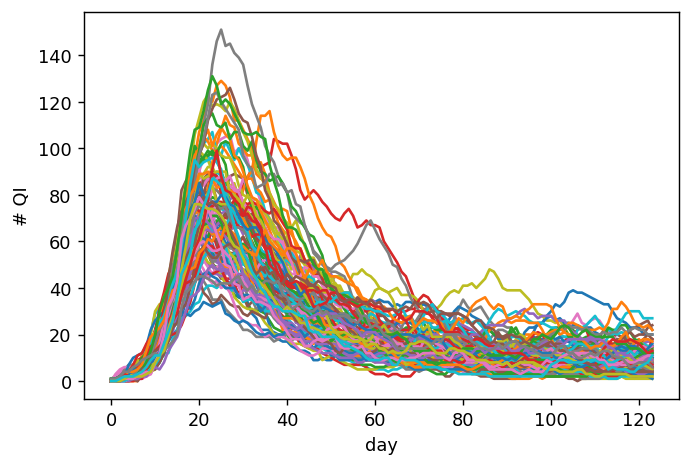

In [342]:
for i in range(n_iter):
    plt.plot(QI_2[i,:])
    
plt.xlabel('day')
plt.ylabel('# QI')

Text(0, 0.5, '# QS')

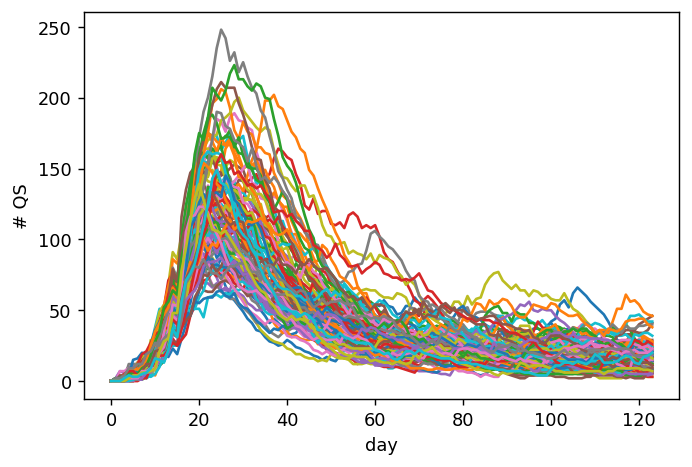

In [343]:
for i in range(n_iter):
    plt.plot(QS_2[i,:])
    
plt.xlabel('day')
plt.ylabel('# QS')

Text(0, 0.5, '# free and infectious')

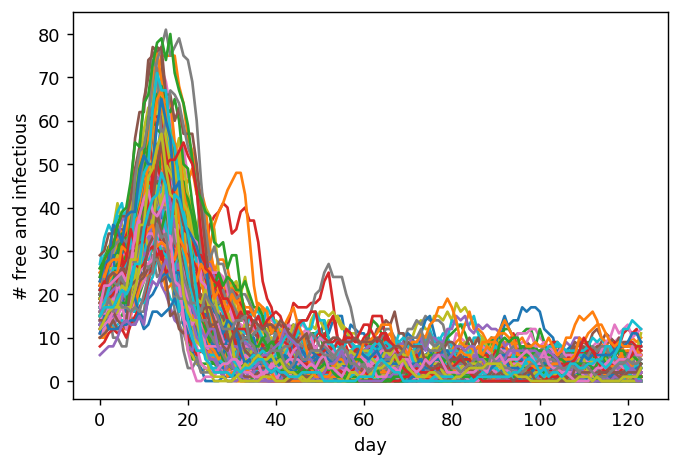

In [344]:
for i in range(n_iter):
    plt.plot(free_and_infectious_2[i,:])
    
plt.xlabel('day')
plt.ylabel('# free and infectious')

In [345]:
np.percentile(np.max(QI_2 + QS_2, axis=1), 50)

198.0

In [346]:
np.percentile(np.max(QI_2 + QS_2, axis=1), 90)

280.3

In [347]:
Q_2 = QI_2 + QS_2
np.percentile(np.max(Q_2[:, 36:], axis=1), 50)

123.5

In [348]:
np.percentile(np.max(Q_2[:, 36:], axis=1), 90)

206.80000000000007